In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

### 미국 S&P500 지수를 추종하는 ETF SPY를 이용해 데이터 분석을 해보았다.

### 3. Box-Jenkins ARIMA Procedure
-  3.1 Data Preprocessing
-  3.2 Identify Model to be Tentatively Entertainted
-  3.3 Estimate Parameters
-  3.4 Diagnosis Check
-  3.5 use Model to Forecast

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/시계열 스터디/3주차/SPY.csv")

In [ ]:
data.head() #역순으로 되어있다. 순서를 바꿔보자.

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2023- 03- 22,398.45,398.81,399.87,398.10,23.40M,-0.12%
1,2023- 03- 21,398.91,397.24,399.41,395.58,91.15M,1.31%
2,2023- 03- 20,393.74,390.80,394.17,390.07,92.25M,0.96%
3,2023- 03- 17,389.99,393.22,394.40,388.55,140.55M,-1.55%
4,2023- 03- 16,396.11,386.82,396.47,386.29,141.32M,1.75%


종가, 날짜 두가지 데이터만 사용해보자

In [ ]:
data = data[::-1]
data = data[['날짜','종가']]
data['날짜'] = pd.to_datetime(data['날짜']) #날짜를 시계열 데이터로 변환하자.
data.rename(columns = {'종가':'price', '날짜':'date'},inplace = True)
data.set_index('date', inplace=True)

In [ ]:
data.head()

,price
date,
2013-01-02,146.06
2013-01-03,145.73
2013-01-04,146.37
2013-01-07,145.97
2013-01-08,145.55


<Axes: xlabel='date'>

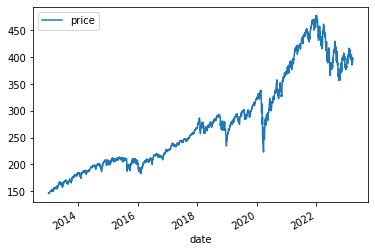

In [ ]:
data.plot()

육안으로 볼 때는 추세는 존재하고, 계절성은 잘 보이지 않는다. 먼저 비정상성 데이터인지부터 확인을 해보자

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


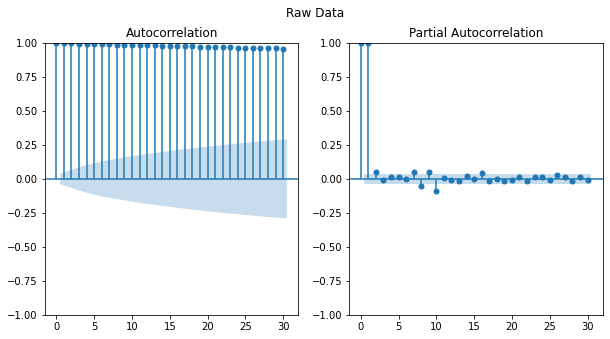

In [ ]:
#ACF, PACF
def acf_pacf(data, lag):
  fig, ax = plt.subplots(1,2,figsize=(10,5))
  fig.suptitle('Raw Data')
  sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=lag, ax=ax[0])
  sm.graphics.tsa.plot_pacf(data.values.squeeze(), lags=lag, ax=ax[1]); # Modify not to generate graph t

acf_pacf(data, 30)

ACF를 보면 천천히 지수적으로 감소, 즉 비정상성을 띈다고 볼 수 있다. 

이번엔 단위근 검정을 통해 살펴보자

In [ ]:
def test_stationarity(timeseries):
  rolmean = timeseries.rolling(window = 12).mean()
  rolstd = timeseries.rolling(window = 12).std()

  orig = plt.plot(timeseries, color = 'blue', label = 'Origin')
  mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
  st = plt.plot(rolstd, color = 'black', label = 'Rolling std')
  plt.title("Rolling Mean & Standard Deviation")
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = list(adfuller(timeseries))
  dftest[1] = round(dftest[1],5)
  dfoutput = pd.Series(dftest[0:4], index = ['검정통계량', 'p-value, 소숫점 넷째 자리까지', '#Lagging', '#Obeservations'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value,2
  print(dfoutput)

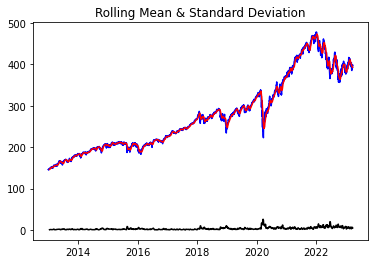

Results of Dickey-Fuller Test:
검정통계량                                  -0.81294
p-value, 소숫점 넷째 자리까지                    0.81529
#Lagging                                   27.0
#Obeservations                           2550.0
Critical Value (1%)      (-3.43291701763171, 2)
Critical Value (5%)     (-2.862674104529329, 2)
Critical Value (10%)    (-2.567373726105344, 2)
dtype: object


In [ ]:
test_stationarity(data)

정상성을 보이지 않음을 다시 확인할 수 있다.

차분을 통해 비정상성이 제거되는지 확인해보자.

In [ ]:
def differencing(data):
  length = len(data)
  data = data - data.shift(1)
  return data[1:]

In [ ]:
diff_data = data.copy()
diff_data = differencing(diff_data)
diff_data.head()

,price
date,
2013-01-03,-0.33
2013-01-04,0.64
2013-01-07,-0.40
2013-01-08,-0.42
2013-01-09,0.37


<Axes: xlabel='date'>

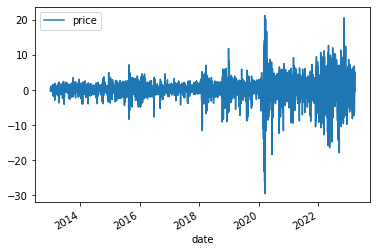

In [ ]:
diff_data.plot() #평균은 일정해졌으나, 분산이 변화함을 확인할 수 있다.

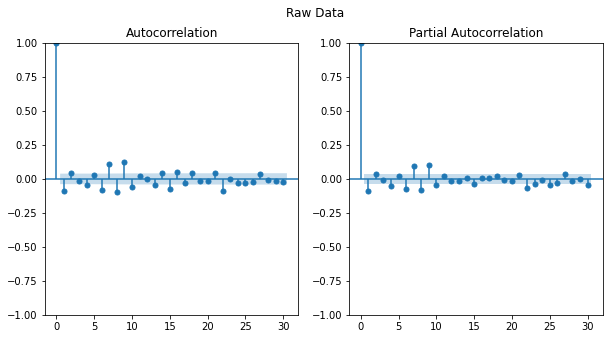

In [ ]:
acf_pacf(diff_data, 30) #ACF, PACF가 대부분 0의 모습을 띈다. 다만 그냥 plot그래프에서 분산이 변화하는게 걸린다.

ADF 검정을 진행해보자.

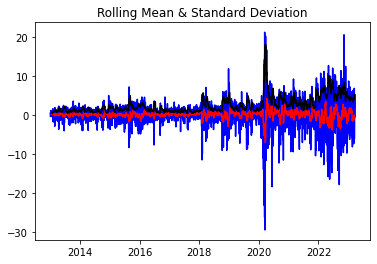

Results of Dickey-Fuller Test:
검정통계량                                -10.836724
p-value, 소숫점 넷째 자리까지                        0.0
#Lagging                                   26.0
#Obeservations                           2550.0
Critical Value (1%)      (-3.43291701763171, 2)
Critical Value (5%)     (-2.862674104529329, 2)
Critical Value (10%)    (-2.567373726105344, 2)
dtype: object


In [ ]:
test_stationarity(diff_data)

우려완 다르게 1차 차분만으로 정상성을 띄는 것을 확인할 수 있다. 

따라서 최종 모델을 1차차분한 데이터를 적용하는 것이 좋아보인다.

이번엔 p와 q를 한번 예측해보자

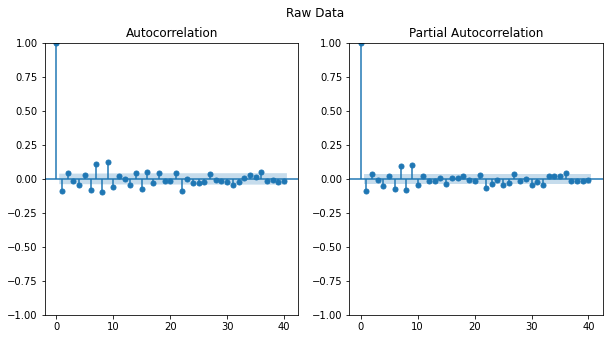

In [ ]:
acf_pacf(diff_data, 40)

먼저 두 그래프 모두 미미하나 지수적으로 감소하는 형태로 보이므로 ARMA라고 생각할 수 있겠고, 

둘다 1번째 시차부터 지수적으로 감소하는 것으로 보인다.이에 ARIMA 모형을 (2,1,1), (1,1,2)로 먼저 생각하고 구현해보려 한다.

In [ ]:
model_211 = ARIMA(data.values, order=(2,1,1))
model_211 = model_211.fit()
model_211.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2578
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -6752.944
Date:                Wed, 22 Mar 2023   AIC                          13513.887
Time:                        17:39:45   BIC                          13537.305
Sample:                             0   HQIC                         13522.376
                               - 2578                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1226      0.244     -0.502      0.615      -0.601       0.356
ar.L2          0.0340      0.025      1.380      0.168      -0.014       0.082
ma.L1          0.0366      0.243      0.151      0.880      -0.440       0.513
sigma2        11.0569      0.138     80.316      0.000      10.787      11.327
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9201.08
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              10.31   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_112 = ARIMA(data.values, order=(1,1,2))
model_112 = model_112.fit()
model_112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2578
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6752.801
Date:                Wed, 22 Mar 2023   AIC                          13513.603
Time:                        17:41:17   BIC                          13537.020
Sample:                             0   HQIC                         13522.091
                               - 2578                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1620      0.186     -0.869      0.385      -0.527       0.203
ma.L1          0.0764      0.185      0.413      0.680      -0.287       0.439
ma.L2          0.0340      0.020      1.721      0.085      -0.005       0.073
sigma2        11.0562      0.137     80.502      0.000      10.787      11.325
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9157.41
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              10.30   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

두 모델만으로 비교하면 AIC 기준 112가 좀 더 낫긴 하다. 

이번엔 autoarima를 이용해 실제 알고리즘상 어떤 파라미터가 가장 최적인지 확인해보자.

In [ ]:
# Parameter search 

auto_arima_model = auto_arima(data, start_p=1, start_q=1,
                              max_p=5, max_q=5, d=1,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=13531.910, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=13514.344, Time=1.82 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=13511.585, Time=2.47 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=13512.267, Time=2.66 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=13510.701, Time=2.56 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=13511.617, Time=3.88 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=13512.818, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=13512.257, Time=1.88 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=13513.143, Time=2.71 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=13512.408, Time=2.17 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=13467.256, Time=4.16 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=13511.437, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=13513.411, Time=1.43 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=13428.766, Time=5.58 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=13512.486, Time=5.05

Best 모델을 보면 거~의 유사했다. 좀 아쉽다.